In [41]:
from __future__ import print_function 
import sys
sys.setrecursionlimit(10**6)
experiment_setup_name = "tutorial.gym.atari.hierarchical.v0"


#gym game title
GAME_TITLE = 'BankHeist-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 5

#how long is one replay session from a batch
#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 50


#theano device selection. GPU is, as always, in preference, but not required
%env THEANO_FLAGS='device=gpu1'



env: THEANO_FLAGS='device=gpu1'


In [42]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[2016-06-07 11:38:52,721] Making new env: BankHeist-v0


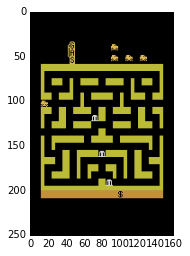

In [43]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [44]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print(action_names)

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [45]:
del atari

# Agent

In [46]:
from controller_class import Controller
controller = Controller(observation_shape,n_actions)

In [47]:
from metacontroller_class import MetaController
metacontroller = MetaController(controller)

In [107]:
from agentnet.utils.layers import get_layer_dtype

#a nice pythonic interface
def step(env_observation, 
         prev_memories = 'zeros',
         batch_size = N_PARALLEL_GAMES,):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    
    if prev_memories == 'zeros':
        controller_mem = metacontroller_mem = 'zeros'
        meta_inp = np.zeros((batch_size,)+tuple(metacontroller.observation_shape[1:]),dtype='float32')
        itr = -1
        #goal will be defined by "if itr ==0" clause
    else:
        pivot = len(controller.agent.state_variables)    
        controller_mem, metacontroller_mem = prev_memories[:pivot],prev_memories[pivot:-4]
        meta_inp, goal, meta_V, itrs = prev_memories[-4:]
        itr = itrs[0]
        
    itr = (itr+1)%metacontroller.period
    
    if itr==0:
        goal,metacontroller_mem,meta_V = metacontroller.step(meta_inp,metacontroller_mem,batch_size)

    
    action,controller_mem,meta_inp = controller.step(env_observation,goal,controller_mem,batch_size)
    
    
    new_memories = controller_mem + metacontroller_mem + [meta_inp, goal,meta_V, [itr]*N_PARALLEL_GAMES ]
    
    return action, new_memories
    
    

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [108]:
from agentnet.experiments.openai_gym.pool import GamePool

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-06-07 14:21:58,623] Making new env: BankHeist-v0
[2016-06-07 14:21:58,647] Making new env: BankHeist-v0
[2016-06-07 14:21:58,670] Making new env: BankHeist-v0
[2016-06-07 14:21:58,692] Making new env: BankHeist-v0
[2016-06-07 14:21:58,715] Making new env: BankHeist-v0


In [110]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(step,50,verbose=True)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['DOWN' 'UPFIRE' 'UPFIRE' 'UPFIRE' 'UPFIRE']
 ['UPFIRE' 'FIRE' 'UPFIRE' 'DOWNRIGHTFIRE' 'RIGHT']
 ['UPFIRE' 'UPFIRE' 'UPFIRE' 'UP' 'UPFIRE']]
CPU times: user 3.78 s, sys: 536 ms, total: 4.32 s
Wall time: 4.41 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [111]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
controller_env = SessionPoolEnvironment(
    observations = controller.agent.observation_layers,
    actions=controller.resolver,
    agent_memories=controller.agent.agent_states)


metacontroller_env = SessionPoolEnvironment(
    observations = metacontroller.agent.observation_layers,
    actions=metacontroller.resolver,
    agent_memories=metacontroller.agent.agent_states)

In [117]:
def update_envs(controller_env,metacontroller_env,pool,
                n_steps=100,split_into = 1):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""
    assert n_steps%split_into == 0

    
    #get interaction sessions
    observation_log,action_tensor,extrinsic_reward_log,memory_log,is_alive_tensor,_= pool.interact(step,n_steps=n_steps)
    batch_size = observation_log.shape[0]
    
    #parse memory seq
    #UNUSED pivot = len(controller.agent.state_variables)
    #UNUSED controller_mem_log, metacontroller_mem_log = memory_log[:pivot],memory_log[pivot:-4]
    meta_obs_log, goal_log,meta_V, itrs = memory_log[-4:]
    itr = itrs[0]
    
    #parse pre-experience memory states 
    preceding_memory_states = list(pool.prev_memory_states)
    pivot = len(controller.agent.state_variables)
    controller_preceding_states = preceding_memory_states[:pivot]
    metacontroller_preceding_states = preceding_memory_states[pivot:-4]

    ###CONTROLLER###
    #load them into experience replay environment for controller
    
    #controller_preceding_states =!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ctrl_shape = (batch_size*split_into,n_steps/split_into)
    
    intrinsic_rewards = np.concatenate([np.zeros([meta_V.shape[0],1]), np.diff(meta_V,axis=1)],axis=1)
    controller_env.load_sessions([observation_log.reshape(ctrl_shape+observation_shape[1:]),
                                  goal_log.reshape(ctrl_shape)],
                      action_tensor.reshape(ctrl_shape),
                      intrinsic_rewards.reshape(ctrl_shape),
                      is_alive_tensor.reshape(ctrl_shape),
                      #controller_preceding_states
                                )
    
    
    ###METACONTROLLER###
    #separate case for metacontroller
    extrinsic_reward_sums = extrinsic_reward_log.reshape([batch_size,-1,metacontroller.period]).sum(axis=-1)
    metacontroller_env.load_sessions(meta_obs_log[:,itr==0],
                      goal_log[:,itr==0],
                      extrinsic_reward_sums,
                      is_alive_tensor[:,itr==0],
                      metacontroller_preceding_states)


In [118]:
#load first  sessions
update_envs(controller_env,metacontroller_env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [119]:
from lasagne.regularization import regularize_network_params, l2
from agentnet.learning import qlearning_n_step

def get_loss(env,agent,replay_seq_len):
    #get agent's Qvalues obtained via experience replay
    _,_,_,_,qvalues_seq = agent.get_sessions(
        env,
        #initial_hidden = env.preceding_agent_memories,
        session_length=replay_seq_len,
        batch_size=env.batch_size,
        optimize_experience_replay=True,
    )

    scaled_reward_seq = env.rewards

    elwise_mse_loss = qlearning_n_step.get_elementwise_objective(qvalues_seq,
                                                            env.actions[0],
                                                            scaled_reward_seq,
                                                            env.is_alive,
                                                            gamma_or_gammas=0.99,
                                                            n_steps=5)

    #compute mean over "alive" fragments
    mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()


    #regularize network weights

    reg_l2 = regularize_network_params(agent.state_variables.keys(),l2)*10**-5


    return mse_loss + reg_l2

In [120]:
loss = get_loss(controller_env,controller.agent,50) + get_loss(metacontroller_env,metacontroller.agent,10)


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [ ]:
weights = controller.weights+metacontroller.weights

In [ ]:
# Compute weight updates
import lasagne
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [ ]:
#mean session reward
mean_session_reward = metacontroller_env.rewards.sum(axis=1).mean()

# Compile train and evaluation functions

In [ ]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mean_session_reward])

# Session visualization tools

Just a helper function that draws current game images.

In [ ]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.games[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

In [ ]:
#visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [ ]:
import os

In [ ]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [ ]:
from agentnet.utils import save,load

In [ ]:
#load(resolver,"/srv/hd7/jheuristic/agentnet_snapshots/heist.epoch7000")

In [ ]:
resolver = controller.resolver

In [ ]:
%%time

n_epochs = 25000
#25k may take hours to train.
#consider interrupt early.



for i in range(n_epochs):    
    
    
    #train
    update_envs(controller_env,metacontroller_env,pool,replay_seq_len)
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%5 ==0:

        ##update learning curves
        full_loss, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_envs(controller_env,metacontroller_env,pool,replay_seq_len)
        
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_envs(controller_env,metacontroller_env,pool,replay_seq_len)
        
        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        
    if epoch_counter %500 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    if epoch_counter %1000 ==0:
        save(resolver,"/srv/hd7/jheuristic/agentnet_snapshots/{}.epoch{}".format("heist",epoch_counter))

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
score_log.plot("final")

In [ ]:
print("Random session examples")
display_sessions()


# Submission
Here we simply run the OpenAI gym submission code and view scores

In [ ]:
resolver.epsilon.set_value(0)

In [ ]:
[m.close() for m in gym.monitoring._open_monitors()]

In [ ]:

save_path = '/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(10):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])
        
        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        t+=1

subm_env.monitor.close()

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__